<a href="https://colab.research.google.com/github/krupaanand312jc/EMG_Hand_Movements_NN/blob/main/EMG_Hand_Movements_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMG based Classification of Basic Hand Movements using CNN



## Clone the Repository containing the Single Channel sEMG Data from GitHub

In [ ]:
! git clone https://github.com/krupaanand312jc/EMG_Hand_Movements_NN

Cloning into 'EMG_Hand_Movements_NN'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 22 (delta 1), reused 18 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.


## Import the required packages

In [ ]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

## Load the dataset from the directory
The Dataset consists 'two' single channel sEMG data collected and filtered  from one healthy male person for 3 consecutive days.
First Channel data is from the muscle 'Flexor Capri Ulnaris' and
Second Channel data is from the muscle 'Extensor Capri Radialis'

In [ ]:
data1 = io.loadmat('/content/EMG_Hand_Movements_NN/Dataset/sEMG_Basic_Hand_movements_upatras/Database 2/male_day_1.mat')
data2 = io.loadmat('/content/EMG_Hand_Movements_NN/Dataset/sEMG_Basic_Hand_movements_upatras/Database 2/male_day_2.mat')
data3 = io.loadmat('/content/EMG_Hand_Movements_NN/Dataset/sEMG_Basic_Hand_movements_upatras/Database 2/male_day_1.mat')

## Preparing the Dataset for training the Neural Network

### Prepare the Data ready for splitting
Our Data contains EMG Signal data containing 6 classes collected from  two single channels for 3 days 

#### Prepare the Label set

In [ ]:
# Fixed params
n_classes = 6
n_channels = 1

split_type = 'train'

train_days = [1, 2, 3]
test_days = [1, 2, 3]

if split_type == 'train':
        split = train_days
else:
        split = test_days

# Assign numeric label to categories:
#
# cyl = 1
# hook = 2
# lat = 3
# palm = 4
# spher = 5
# tip = 6
#

labels = np.concatenate(
        (
            [[class_id for _ in range(100 * len(split))] for class_id in range(1, n_classes + 1)]
        )
    )

#### Prepare the Data set

##### Assign the respective variables for the respective classes and days
**NOTE:** Since our project is based on single channel sEMG Signals, please use the Data from any one channel. 

In [ ]:
# Uncomment this for Channel 1

# cyl_day1 = data1['cyl_ch1']
# hook_day1 = data1['hook_ch1']
# tip_day1 = data1['tip_ch1']
# palm_day1 = data1['palm_ch1']
# spher_day1 = data1['spher_ch1']
# lat_day1 = data1['lat_ch1']

# cyl_day2 = data2['cyl_ch1']
# hook_day2 = data2['hook_ch1']
# tip_day2 = data2['tip_ch1']
# palm_day2 = data2['palm_ch1']
# spher_day2 = data2['spher_ch1']
# lat_day2 = data2['lat_ch1']

# cyl_day3 = data3['cyl_ch1']
# hook_day3 = data3['hook_ch1']
# tip_day3 = data3['tip_ch1']
# palm_day3 = data3['palm_ch1']
# spher_day3 = data3['spher_ch1']
# lat_day3 = data3['lat_ch1']


cyl_day1 = data1['cyl_ch2']
hook_day1 = data1['hook_ch2']
tip_day1 = data1['tip_ch2']
palm_day1 = data1['palm_ch2']
spher_day1 = data1['spher_ch2']
lat_day1 = data1['lat_ch2']

cyl_day2 = data2['cyl_ch2']
hook_day2 = data2['hook_ch2']
tip_day2 = data2['tip_ch2']
palm_day2 = data2['palm_ch2']
spher_day2 = data2['spher_ch2']
lat_day2 = data2['lat_ch2']

cyl_day3 = data3['cyl_ch2']
hook_day3 = data3['hook_ch2']
tip_day3 = data3['tip_ch2']
palm_day3 = data3['palm_ch2']
spher_day3 = data3['spher_ch2']
lat_day3 = data3['lat_ch2']

##### Stack all the data into a single set according to the classes

In [ ]:
X = np.vstack([cyl_day1, cyl_day2, cyl_day3,
               hook_day1, hook_day2, hook_day3,
               lat_day1, lat_day2, lat_day3,
               palm_day1, palm_day2, palm_day3,
               spher_day1, spher_day2, spher_day3,
               tip_day1, tip_day2, tip_day3])

# Drop last 4 data points to more easily subdivide into layers
X = np.delete(X, [2496, 2497, 2498, 2499], 1)

### Split the data into Train, Validation and Test sets

#### Split the Data (X and labels) into Train and Test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.4, random_state=42)

#### Further split the Train set into Train set and Validation sets

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### One-hot encode the labels in train, validation and test sets

In [ ]:
def one_hot(labels, n_class=6):
    """
    One-hot encoding.
    :param labels: Labels to encode.
    :param n_class: Number of classes.
    :return: One-hot encoded labels.
    """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T

    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y


y_train = one_hot(y_train)
y_val = one_hot(y_val)
y_test = one_hot(y_test)

## Training the Neural Network

In [ ]:
# The following were determined through iterative trial and error:
batch_size = 100
seq_len = 2496
learning_rate = 0.00001
epochs = 2500

### Prepare the Model for training

In [ ]:
model = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(seq_len)),

  keras.layers.BatchNormalization(),                                    

  keras.layers.Reshape(target_shape=(seq_len, n_channels)),

  # (batch, 2496, 1) --> (batch, 1248, 2)
  keras.layers.Conv1D(filters=2, kernel_size=1, strides=1, padding='same', activation = 'relu'),
  tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same'),

  # (batch, 1248, 2) --> (batch, 624, 4)
  tf.keras.layers.Conv1D(filters=4, kernel_size=1, strides=1, padding='same', activation = 'relu'),
  tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same'),

  # (batch, 624, 4) --> (batch, 312, 8)
  tf.keras.layers.Conv1D(filters=8, kernel_size=1, strides=1, padding='same', activation = 'relu'),
  tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same'),

  # (batch, 312, 8) --> (batch, 156, 16)
  tf.keras.layers.Conv1D(filters=16, kernel_size=1, strides=1, padding='same', activation = 'relu'),
  tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same'),

  # (batch, 156, 16) --> (batch, 78, 32)
  tf.keras.layers.Conv1D(filters=32, kernel_size=1, strides=1, padding='same', activation = 'relu'),
  tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same'),

  # (batch, 78, 32) --> (batch, 39, 64)
  tf.keras.layers.Conv1D(filters=64, kernel_size=1, strides=1, padding='same', activation = 'relu'),
  tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same'),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(156, activation='relu'),

  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Dense(18, activation='relu'),

  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Dense(n_classes, activation='softmax')

]) 

### Compile and Train the model

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = batch_size, epochs=epochs)

Streaming output truncated to the last 5000 lines.
Epoch 1/2500
9/9 [==============================] - 4s 82ms/step - loss: 1.7960 - accuracy: 0.1519 - val_loss: 1.7885 - val_accuracy: 0.1778
Epoch 2/2500
9/9 [==============================] - 0s 8ms/step - loss: 1.7938 - accuracy: 0.1605 - val_loss: 1.7865 - val_accuracy: 0.1852
Epoch 3/2500
9/9 [==============================] - 0s 8ms/step - loss: 1.7920 - accuracy: 0.1580 - val_loss: 1.7848 - val_accuracy: 0.1852
Epoch 4/2500
9/9 [==============================] - 0s 9ms/step - loss: 1.7884 - accuracy: 0.1802 - val_loss: 1.7832 - val_accuracy: 0.1852
Epoch 5/2500
9/9 [==============================] - 0s 10ms/step - loss: 1.7875 - accuracy: 0.1691 - val_loss: 1.7815 - val_accuracy: 0.1852
Epoch 6/2500
9/9 [==============================] - 0s 9ms/step - loss: 1.7858 - accuracy: 0.1667 - val_loss: 1.7801 - val_accuracy: 0.1852
Epoch 7/2500
9/9 [==============================] - 0s 8ms/step - loss: 1.7821 - accuracy: 0.1753 - val_los

### Evaluate the Model

In [ ]:
model.evaluate(X_test, y_test, batch_size=batch_size)

8/8 [==============================] - 0s 20ms/step - loss: 0.7590 - accuracy: 0.7403


[0.7590228319168091, 0.7402777671813965]

In [ ]:
model.metrics_names

['loss', 'accuracy']

### Plot the Train and Validation Losses and Accuracies

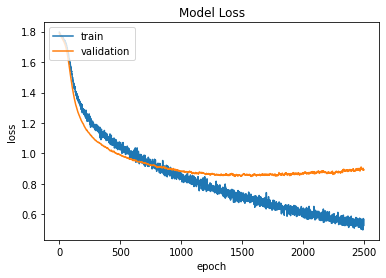

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

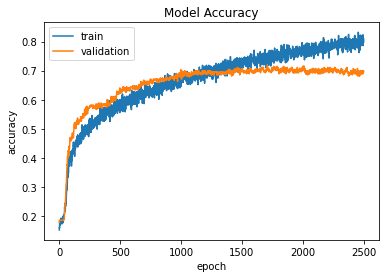

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

### Confusion Matrix

In [ ]:
#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('\033[1m'+'Confusion Matrix\n')
print('\033[0m')
print(confusion)

Confusion Matrix


[[ 98   0   0   0  15   0]
 [  3 101  12   6   6   8]
 [  0  12  76  15   0  11]
 [  1  17   6  68   3  13]
 [ 15   6   4   2 112   0]
 [  0   6   9  16   1  78]]


### Analyse various Metrics for each of the 6 classes

In [ ]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\033[1m' + '\nClassification Report\n')
print('\033[0m' + classification_report(y_test, y_pred, target_names=['Cylindrical', 'Hook', 'Lateral', 'Palmer', 'Spherical', 'tip']))


Accuracy: 0.74

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Macro Precision: 0.74
Macro Recall: 0.74
Macro F1-score: 0.74

Weighted Precision: 0.74
Weighted Recall: 0.74
Weighted F1-score: 0.74

Classification Report

              precision    recall  f1-score   support

 Cylindrical       0.84      0.87      0.85       113
        Hook       0.71      0.74      0.73       136
     Lateral       0.71      0.67      0.69       114
      Palmer       0.64      0.63      0.63       108
   Spherical       0.82      0.81      0.81       139
         tip       0.71      0.71      0.71       110

    accuracy                           0.74       720
   macro avg       0.74      0.74      0.74       720
weighted avg       0.74      0.74      0.74       720



## Save the Model 

In [ ]:
saved_model = 'saved_model'
tf.saved_model.save(model, saved_model)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: saved_model/assets


## Generate the Tensorflow lite Model

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model)

tflite_model = converter.convert()

import pathlib

tflite_model_file = pathlib.Path('model.tflite')
print(f'Size of the tflite model without Quantization is {tflite_model_file.write_bytes(tflite_model)/1000} kb')

Size of the tflite model without Quantization is 1614.852 kb


### Post Training Quantization

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]    

tflite_model = converter.convert()

import pathlib

tflite_model_file = pathlib.Path('model_1.tflite')
print(f'Size of the tflite model with Quantization is {tflite_model_file.write_bytes(tflite_model)/1000} kb')

Size of the tflite model with Quantization is 434.496 kb


## Generate the TensorFlow Lite for Microcontrollers Model
To convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers on Arduino we need to use the ```xxd``` tool to convert the ```.tflite``` file into a ```.cc``` file.

In [ ]:
!apt-get update && apt-get -qq install xxd

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [62.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:13 https://developer.download.nvi

In [ ]:
MODEL_TFLITE = 'model_1.tflite'
MODEL_TFLITE_MICRO = 'EMG_NN.cc'
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Run the cell below to print out its contents which we'll need for our next step, deploying the model using the Arudino IDE!

In [ ]:
!cat {MODEL_TFLITE_MICRO}

Streaming output truncated to the last 5000 lines.
  0x27, 0xfa, 0xe5, 0xef, 0xfa, 0xe8, 0xf4, 0xd1, 0x22, 0xef, 0xfe, 0x2c,
  0x15, 0xfc, 0xe8, 0x07, 0xf8, 0xe3, 0x01, 0x08, 0x17, 0xe4, 0xf2, 0xe0,
  0x26, 0x1b, 0xdb, 0x14, 0x15, 0x13, 0xf3, 0xf6, 0x39, 0x0d, 0x19, 0x0d,
  0xe7, 0x34, 0x37, 0xf6, 0x16, 0x08, 0xfb, 0x01, 0xf5, 0xeb, 0xe8, 0xef,
  0xf9, 0x25, 0x06, 0x24, 0x2a, 0xdc, 0xf7, 0x2c, 0x24, 0x15, 0x0b, 0xd1,
  0x2a, 0xf5, 0x00, 0x21, 0x0c, 0x22, 0xff, 0xdc, 0xf1, 0x3d, 0x0c, 0x0b,
  0xe9, 0x19, 0x22, 0xee, 0x0d, 0xcb, 0xee, 0xe0, 0xfe, 0x06, 0xfe, 0x15,
  0xd7, 0xfe, 0x00, 0xeb, 0x27, 0xd7, 0x02, 0x22, 0x28, 0xed, 0x27, 0x40,
  0x29, 0x2b, 0x3f, 0x20, 0x24, 0xed, 0x00, 0x19, 0xfa, 0x35, 0x03, 0xfe,
  0x0c, 0xe2, 0x2f, 0xea, 0x37, 0xe9, 0xe9, 0xe5, 0xef, 0xda, 0xef, 0xfa,
  0x0e, 0xea, 0xdd, 0x0d, 0xe4, 0x1e, 0x0c, 0xfb, 0x01, 0x14, 0x04, 0x20,
  0xd2, 0xf1, 0xc8, 0x0e, 0xd7, 0x14, 0x0c, 0xf7, 0xf1, 0x05, 0x06, 0x1b,
  0xed, 0xff, 0x03, 0x15, 0xe1, 0x12, 0x2b, 0x16, 0xf8, 0xd7,